In [1]:
 # ################################################
 #            MOLECULE SPECIFICATION              #
 # ################################################

#basis = "631+g"; 
charge = 0
basis="sto6g"

geometry = [['N', [2.01085434e+00,  2.41275446e-01, 3.58127897e-03]],
            ['N', [ 4.32105011e+00,  3.93732487e-02, -1.03034961e-01]],
            ['H', [ 1.16695296e+00, -1.27702289e+00, -7.95455978e-01]],
            ['H', [ 5.16495323e+00,  1.55781182e+00,  6.95732527e-01]]]

In [2]:
from inquanto.geometries import GeometryMolecular
from inquanto.extensions.nglview import VisualizerNGL

n2h2_geom = GeometryMolecular(geometry)
visualizer = VisualizerNGL(n2h2_geom)
visualizer.visualize_molecule(atom_labels="index")

NGLWidget()

In [3]:
from inquanto.extensions.pyscf import ChemistryDriverPySCFMolecularRHF

driver = ChemistryDriverPySCFMolecularRHF(geometry=n2h2_geom.xyz, basis=basis)

cube_orbitals=driver.get_cube_orbitals()
ngl_mos = [visualizer.visualize_orbitals(orb) for orb in cube_orbitals]
ngl_mos[7]

NGLWidget()

In [4]:
len(ngl_mos)

12

In [5]:
# ################################################## #
#             PRELIMINARY CALCULATIONS               #
# ################################################## #

from inquanto.extensions.pyscf import ChemistryDriverPySCFMolecularRHF, FromActiveSpace, CASSCF
from scipy.linalg import eigh

ncas = 4
nelecas = 4
active_space = FromActiveSpace(ncas=ncas, nelecas=nelecas)
casscf = CASSCF(ncas=ncas, nelecas=nelecas)
driver = ChemistryDriverPySCFMolecularRHF(basis=basis, geometry=geometry, charge=charge, frozen=active_space, transf=casscf, point_group_symmetry=True)
chemistry_hamiltonian, fock_space, hartree_fock_state = driver.get_system()
hartree_fock_energy = driver.mf_energy

print('HARTREE FOCK ENERGY: {}\n'.format(hartree_fock_energy))

<string>:1053: UserWarning: Warning! Symmetry information for systems with point groups other than C2v, D2h, Coov and Dooh are sometimes unreliable from this driver!


HARTREE FOCK ENERGY: -108.74036722308217



In [6]:
fermionic_hamiltonian = chemistry_hamiltonian.to_FermionOperator()


print('SECOND QUANTIZED HAMILTONIAN PRINTED:\n{}\n'.format(fermionic_hamiltonian))
print('SECOND QUANTIZED HAMILTONIAN AS DATAFRAME: {}\n'.format(driver._mf.mo_occ))
print('HARTREE FOCK ENERGY: {}\n'.format(hartree_fock_energy))
print('FOCK SPACE AND THE HARTREE-FOCK STATE OCCUPATIONS: ')
fock_space.print_state(hartree_fock_state)

SECOND QUANTIZED HAMILTONIAN PRINTED:
(-105.05002566228524, ), (-1.6367247345774751, F0^ F0 ), (-1.1000829988883512e-08, F0^ F2 ), (-2.282929713499915e-08, F0^ F6 ), (-1.1000829911188674e-08, F2^ F0 ), (-1.5815670454453805, F2^ F2 ), (-2.8746110191463073e-08, F2^ F4 ), (-2.874610994506119e-08, F4^ F2 ), (-1.5608816506486425, F4^ F4 ), (-2.2579484914860052e-08, F4^ F6 ), (-2.2829296938758556e-08, F6^ F0 ), (-2.257948490016096e-08, F6^ F4 ), (-1.5483654516075318, F6^ F6 ), (-1.6367247345774751, F1^ F1 ), (-1.1000829988883512e-08, F1^ F3 ), (-2.282929713499915e-08, F1^ F7 ), (-1.1000829911188674e-08, F3^ F1 ), (-1.5815670454453805, F3^ F3 ), (-2.8746110191463073e-08, F3^ F5 ), (-2.874610994506119e-08, F5^ F3 ), (-1.5608816506486425, F5^ F5 ), (-2.2579484914860052e-08, F5^ F7 ), (-2.2829296938758556e-08, F7^ F1 ), (-2.257948490016096e-08, F7^ F5 ), (-1.5483654516075318, F7^ F7 ), (0.430077832501432, F2^ F0^ F0  F2 ), (0.43267735666038853, F4^ F0^ F0  F4 ), (1.4279340119810642e-07, F4^ F0^ 

In [7]:
import sympy as sp
sp.Matrix(driver._mf.mo_occ)

Matrix([
[2.0],
[2.0],
[2.0],
[2.0],
[2.0],
[2.0],
[2.0],
[2.0],
[  0],
[  0],
[  0],
[  0]])

In [8]:
# convert the chemistry_hamiltonian object to a FermionOperator object (to work in the fermionic basis)
fermionic_hamiltonian = chemistry_hamiltonian.to_FermionOperator()

# convert the FermionOperator object to a qubit Hamiltonian using the Jordan-Wigner encoding scheme (ham in terms of qubits operator)
qubit_ham = fermionic_hamiltonian.qubit_encode()

# convert the qubit Hamiltonian to a sparse matrix
qubit_ham_matrix = qubit_ham.to_sparse_matrix().todense()

ValueError: x and y must have same first dimension, but have shapes (16,) and (256,)

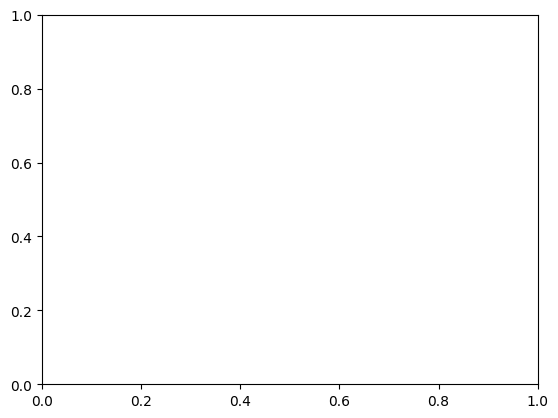

In [9]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1, 17)], list(eigh(qubit_ham_matrix)[0]), 'ro')
plt.axis([0, 17, -109, -107])
plt.xlabel("E_i")
plt.ylabel("Eigenenergies")
plt.show()


In [10]:
# calculate the excitation energy 
exc_energy = list(eigh(qubit_ham_matrix)[0])[1] - min(list(eigh(qubit_ham_matrix)[0])); 

# calculate the excitation wavelength 
exc_wavelength = 1240 / (exc_energy*27.2107)

print(f"Excitation energy: {exc_energy*27.2107} eV")
print(f"Excitation wavelength: {exc_wavelength} nm")

Excitation energy: 0.12722764352276722 eV
Excitation wavelength: 9746.309572872846 nm


In [13]:

from inquanto.spaces import FermionSpace
from inquanto.protocols import ProtocolDirect
from pytket.extensions.qiskit import AerStateBackend
from inquanto.mappings import QubitMappingJordanWigner
from inquanto.ansatzes import FermionSpaceAnsatzUCCSD
from inquanto.computables import ComputableQSEMatrices
from inquanto.algorithms import AlgorithmQSE
from inquanto.algorithms import AlgorithmVQE
from inquanto.computables import ExpectationValue
from inquanto.protocols import ProtocolStateVectorSparse
from inquanto.minimizers import MinimizerScipy


hamiltonian = fermionic_hamiltonian
n_electron = 4 #3
n_orbitals = 4 #3
fermion_space = FermionSpace(2 * n_orbitals)
fermion_state = fermion_space.generate_occupation_state(
    n_fermion=n_electron,
)

backend = AerStateBackend()
minimizer = MinimizerScipy()

mapping = QubitMappingJordanWigner()
qubit_hamiltonian = mapping.operator_map(fermionic_hamiltonian)


ansatz = FermionSpaceAnsatzUCCSD(fermion_space, fermion_state, mapping)



expectation_value = ExpectationValue(ansatz, qubit_hamiltonian)



initial_parameters = ansatz.state_symbols.construct_zeros()


vqe = AlgorithmVQE(
    objective_expression=expectation_value,
    minimizer=minimizer,
    initial_parameters=initial_parameters)



protocol_expression = ProtocolStateVectorSparse()




vqe.build(
    backend=backend,
    protocol_expression=protocol_expression)


vqe.run()
print(vqe.generate_report())

# TIMER BLOCK-0 BEGINS AT 2023-04-22 10:17:16.837999
# TIMER BLOCK-0 ENDS - DURATION (s): 1133.1919596 [0:18:53.191960]
{'minimizer': {'final_value': -109.18291599949123, 'final_parameters': array([-3.98816066e-05, -3.17359434e-05, -1.05255436e-04,  3.38368170e-05,
       -4.48980898e-05, -5.17009926e-05,  3.93288309e-05,  2.45796778e-05,
       -3.46655490e-02,  8.71767557e-06, -7.88181484e-02,  3.34304907e-05,
       -2.23801114e-01,  3.53248598e-05, -5.38412949e-01, -1.87764341e-01,
        1.58529856e-05,  8.11917046e-06, -2.64425961e-01, -9.22846002e-02,
       -1.80792140e-01,  1.68664877e-05, -6.58767842e-01,  2.91432685e-06,
        4.37063157e-05, -3.33411155e-02])}, 'final_value': -109.18291599949123, 'initial_parameters': [{'ordering': 0, 'symbol': 's0', 'value': 0.0}, {'ordering': 1, 'symbol': 's1', 'value': 0.0}, {'ordering': 2, 'symbol': 's2', 'value': 0.0}, {'ordering': 3, 'symbol': 's3', 'value': 0.0}, {'ordering': 4, 'symbol': 's4', 'value': 0.0}, {'ordering': 5, 'symb

In [ ]:
vqe.final_value

In [ ]:
#[-3.98816066e-05, -3.17359434e-05, -1.05255436e-04,  3.38368170e-05,
      #  -4.48980898e-05, -5.17009926e-05,  3.93288309e-05,  2.45796778e-05,
      #  -3.46655490e-02,  8.71767557e-06, -7.88181484e-02,  3.34304907e-05,
      #  -2.23801114e-01,  3.53248598e-05, -5.38412949e-01, -1.87764341e-01,
      #   1.58529856e-05,  8.11917046e-06, -2.64425961e-01, -9.22846002e-02,
      #  -1.80792140e-01,  1.68664877e-05, -6.58767842e-01,  2.91432685e-06,
      #   4.37063157e-05, -3.33411155e-02]

In [16]:
jw = QubitMappingJordanWigner()
qubit_hamiltonian = jw.operator_map(hamiltonian)
ansatz = FermionSpaceAnsatzUCCSD(fermion_space, fermion_state, qubit_mapping=jw)


expansion_operators = jw.operator_map(
    fermion_space.generate_subspace_singlet_singles()
)


vqe_parameters = ansatz.state_symbols.construct_from_array(
    [-3.98816066e-05, -3.17359434e-05, -1.05255436e-04,  3.38368170e-05,
       -4.48980898e-05, -5.17009926e-05,  3.93288309e-05,  2.45796778e-05,
       -3.46655490e-02,  8.71767557e-06, -7.88181484e-02,  3.34304907e-05,
       -2.23801114e-01,  3.53248598e-05, -5.38412949e-01, -1.87764341e-01,
        1.58529856e-05,  8.11917046e-06, -2.64425961e-01, -9.22846002e-02,
       -1.80792140e-01,  1.68664877e-05, -6.58767842e-01,  2.91432685e-06,
        4.37063157e-05, -3.33411155e-02]
)

computable = ComputableQSEMatrices(
    state=ansatz,
    hermitian_operator=qubit_hamiltonian,
    expansion_operators=expansion_operators,
)

algorithm = AlgorithmQSE(
    computable_qse_matrices=computable,
    parameters=vqe_parameters,
)


protocol_expression = ProtocolDirect()
backend = AerBackend()

algorithm.build(
    backend=backend,
    objective_protocol=protocol_expression,
    n_shots=2000,
)

algorithm.run()
print(algorithm.generate_report())

In [ ]:
final_value = sorted([-184.62305273, -109.65665377, -108.42380041,  -88.00473824])


# calculate the excitation energy 
exc_energyc = (final_value[1] - final_value[0])*27.2107; 

# calculate the excitation wavelength 
exc_wavelengthc = 1240 / (exc_energyc)

print(f"Excitation energy: {exc_energyc} eV")
print(f"Excitation wavelength: {exc_wavelengthc} nm")

Excitation energy: 2039.888192180872 eV
Excitation wavelength: 0.6078764535983217 nm


-108.58381567